# Analyses relating behaviour to psychopathology

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale, minmax_scale
from bambi import Model
import seaborn as sns
from scipy.stats.distributions import halfcauchy
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from tqdm import tqdm
from collections import OrderedDict
import os
import matplotlib
from matplotlib.lines import Line2D
import matplotlib.font_manager as font_manager
prop = matplotlib.font_manager.FontProperties(fname="c:\\windows\\fonts\\nunitosans-light.ttf")
matplotlib.rcParams['font.family'] = prop.get_name()
matplotlib.rcParams['font.weight'] = 'light'
matplotlib.rcParams['axes.facecolor'] = '#fbfbfb'

pal = ['#4f4f4f', '#B80044', '#0e79b2', '#861388', '#171a21', '#a5a5a5']
light_pal =['#9e9e9e', '#e86d9a', '#64abd1']

C:\Users\Toby\Anaconda2\envs\attention\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def construct_equation(predictors, outcome):

    """
    Constructs a regression equation for bambi
    Args:
        predictors: predictor variables, list of strings
        outcome: outcome variable, single string

    Returns:
        Equation of the form y ~ x1 + x2...
    """

    eq_string = '{0} ~ '.format(outcome)

    if isinstance(predictors, dict):
        predictors = predictors.values()

    for n, i in enumerate(predictors):
        if n == 0:
            eq_string += '{0}'.format(i)
        else:
            eq_string += ' + {0}'.format(i)

    return eq_string

## Combine questionnaire and modelling data

Here we get the questionnare data (`qns`), scores on the avoidance test (`avoidance`), and modelling-derived variables such as update parameters and value/uncertainty estimates (`modelling`).

In [3]:
qns = pd.read_csv('../Data/qns_full.csv')
modelling = pd.read_csv('../Data/subject_param_values.csv')
avoidance = pd.read_csv('../Data/avoidance_test_scores.txt', header=None)
avoidance.columns=['Subject', 'mean_health']
avoidance.Subject = avoidance.Subject.str.replace(' ', '')
avoidance = avoidance.drop_duplicates('Subject', keep='last')
full_df = pd.merge(qns, modelling, on='Subject')
full_df = pd.merge(full_df, avoidance, on='Subject')
full_df = full_df[[i for i in full_df.columns if not 'Unnamed' in i]]
full_df = full_df.drop_duplicates('Subject')
full_df = full_df.dropna()[:400]
print "Number of subjects = {0}".format(len(full_df))

Number of subjects = 400


### Run some checks

Check that:

* We don't have any data with missing or invalid values
* We don't have any negative values in things that shouldn't have negative values (factor scores are already scaled so these may have negative values)
* We don't have duplicate subjects

In [4]:
assert full_df.Subject.value_counts().max() == 1, 'Duplicate subject IDs'
assert np.any(full_df.isnull()) == False, 'NaNs or Infs present in data'
assert np.any(full_df.drop('mean_pe', axis=1).iloc[:, 4:] < 0) == False, 'Values below zero'

## Look at data distributions

Now we'll look at the distributions of our variables to make sure nothing weird is going on.

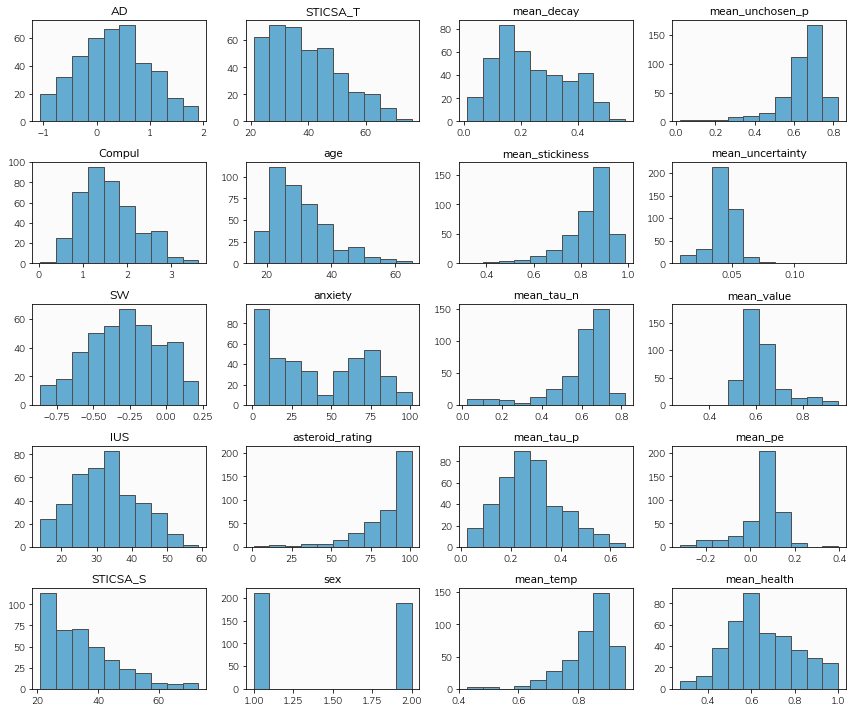

In [5]:
vars = [i for i in full_df.columns if 'Subject' not in i and 'hpd' not in i and 'sd_' not in i and 'mc_error' not in i]

f, ax = plt.subplots(5, np.ceil(len(vars) / 5.).astype(int), figsize=(12, 10), facecolor='white')

for n, var in enumerate(vars):
    ax[n % 5, n / 5].hist(full_df[var], ec=pal[0], color=light_pal[2])
    ax[n % 5, n / 5].set_title(var)
    
plt.tight_layout()

## Subjective anxiety and avoidance

After the task we ask people how anxious it made them feel and how much they wanted to avoid the asteroids.

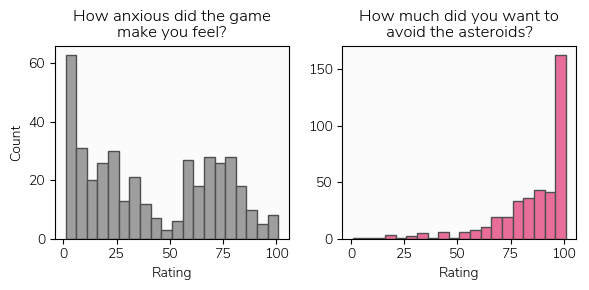

In [6]:
f, ax = plt.subplots(1, 2, figsize=(6, 3), dpi=100, facecolor='white')

ax[0].hist(full_df['anxiety'], ec=pal[0], bins=20, color=light_pal[0])
ax[0].set_xlabel("Rating", fontweight='light')
ax[0].set_ylabel("Count", fontweight='light')
ax[0].set_title("How anxious did the game\nmake you feel?", fontweight='light')

ax[1].hist(full_df['asteroid_rating'], ec=pal[0], bins=20, color=light_pal[1])
ax[1].set_xlabel("Rating", fontweight='light')
ax[1].set_title("How much did you want to\navoid the asteroids?", fontweight='light');

plt.tight_layout()

plt.savefig('subjective_ratings.png')
plt.savefig('subjective_ratings.svg')

### Relationships with state + trait anxiety

There might be some interesting relationships between task-induced anxiety and state/trait anxiety - let's have a look.

C:\Users\Toby\Anaconda2\envs\attention\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


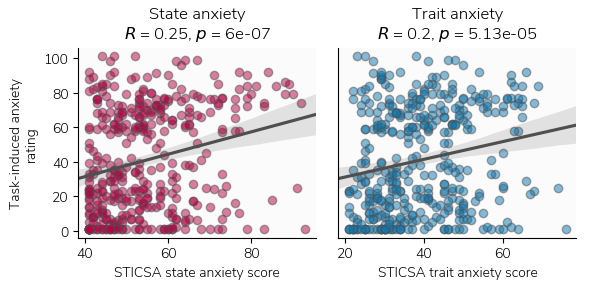

In [7]:
f, ax = plt.subplots(1, 2, figsize=(6, 3), dpi=100, facecolor='white')

state_r = pearsonr(full_df['STICSA_S'], full_df['anxiety'])
trait_r = pearsonr(full_df['STICSA_T'], full_df['anxiety'])

full_df['STICSA_S']

full_df['STICSA_S'] += 20
# full_df['STICSA_T'] -= 20

sns.regplot('STICSA_S', 'anxiety', data=full_df, ax=ax[0], color=pal[1], scatter_kws={'alpha': 0.5, 'edgecolor': pal[0]}, line_kws={'color': pal[0]})
sns.regplot('STICSA_T', 'anxiety', data=full_df, ax=ax[1], color=pal[2], scatter_kws={'alpha': 0.5, 'edgecolor': pal[0]}, line_kws={'color': pal[0]})

ax[0].set_title("State anxiety\n$R$ = {0}, $p$ = {1}".format(np.round(state_r[0], 2), np.round(state_r[1], 7)), fontweight='light')
ax[1].set_title("Trait anxiety\n$R$ = {0}, $p$ = {1}".format(np.round(trait_r[0], 2), np.round(trait_r[1], 7)), fontweight='light')

ax[0].set_xlabel('STICSA state anxiety score', fontweight='light')
ax[1].set_xlabel('STICSA trait anxiety score', fontweight='light')

ax[0].set_ylabel('Task-induced anxiety\nrating', fontweight='light')
ax[1].set_ylabel('')

ax[1].set_yticks([])
ax[1].set_yticklabels([])
sns.despine()

sns.despine()
plt.tight_layout()

# Save figures
plt.savefig('subjective_ratings_STICSA.png')
plt.savefig('subjective_ratings_STICSA.svg')

## Regressions

Scale data before entering into regressions (if not beta distributed) to between zero and 1 (this means we have equivalent scales across all variables) and transform beta-distributed variables to remove values of 0 and 1.

In [10]:
unscaled = ['Subject']
full_df[[c for c in full_df.columns if c not in unscaled]] = scale(full_df[[c for c in full_df.columns if c not in unscaled]])

full_df.head()

C:\Users\Toby\Anaconda2\envs\attention\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  


,AD,Compul,SW,Subject,IUS,STICSA_S,STICSA_T,age,anxiety,asteroid_rating,...,hpd_97.5_decay,hpd_97.5_stickiness,hpd_97.5_tau_n,hpd_97.5_tau_p,hpd_97.5_temp,hpd_97.5_unchosen_p,mean_uncertainty,mean_value,mean_pe,mean_health
0,-0.328644,-0.662831,-0.776643,54f74bc3fdf99b46ee467b27,0.051788,0.365019,-0.761043,-0.356639,-1.311380,-1.123572,...,-0.908014,0.541686,0.108498,-0.516768,-1.336367,0.212972,-0.117059,-0.563285,0.667788,0.131824
1,1.577596,0.074454,1.264454,550c3ed5fdf99b3039d68894,1.905269,-0.497910,0.159152,0.187433,-0.719594,0.342311,...,1.822024,0.470074,0.354710,-0.876186,0.516912,0.415662,0.029343,-0.187683,0.229322,-0.179522
2,-0.071180,0.302968,1.105182,556db04dfdf99b26054b1768,0.814986,-0.239031,0.661076,-0.356639,-0.588087,0.233727,...,0.398062,-0.063168,0.479015,0.166943,0.625786,0.414944,-0.264011,0.333365,-0.367955,-1.017432
3,0.751964,0.181690,0.919872,55747e4afdf99b6752df4183,-0.057240,0.192433,-1.012005,1.057947,1.647547,0.830939,...,0.615894,0.628710,0.525646,-0.523642,-0.286365,0.460260,0.370770,-0.122821,0.107415,-0.326645
4,0.780654,0.213023,1.131550,557c0bd8fdf99b120dc45dde,0.160817,1.831997,0.912038,0.949133,-0.818225,-1.286448,...,-0.092845,-5.087646,-1.066289,1.336712,0.773395,0.372051,-0.311677,1.984374,-2.043621,-0.921059


Check that the data is scaled properly

In [11]:
assert np.any(full_df[[c for c in full_df.columns if c not in unscaled]].mean().round() != 0) == False, 'Scaling failed, mean != 0'
assert np.any(full_df[[c for c in full_df.columns if c not in unscaled]].std().round() != 1) == False, 'Scaling failed, sd != 1'
# assert np.any(full_df[[c for c in full_df.columns if c not in unscaled]] >= 1) == False, 'Found 1s in beta-distributed variables'
# assert np.any(full_df[[c for c in full_df.columns if c not in unscaled]] <= 0) == False, 'Found 0s in beta-distributed variables'
assert np.any(full_df.isnull()) == False, 'Missing data'

## Correlations between variables

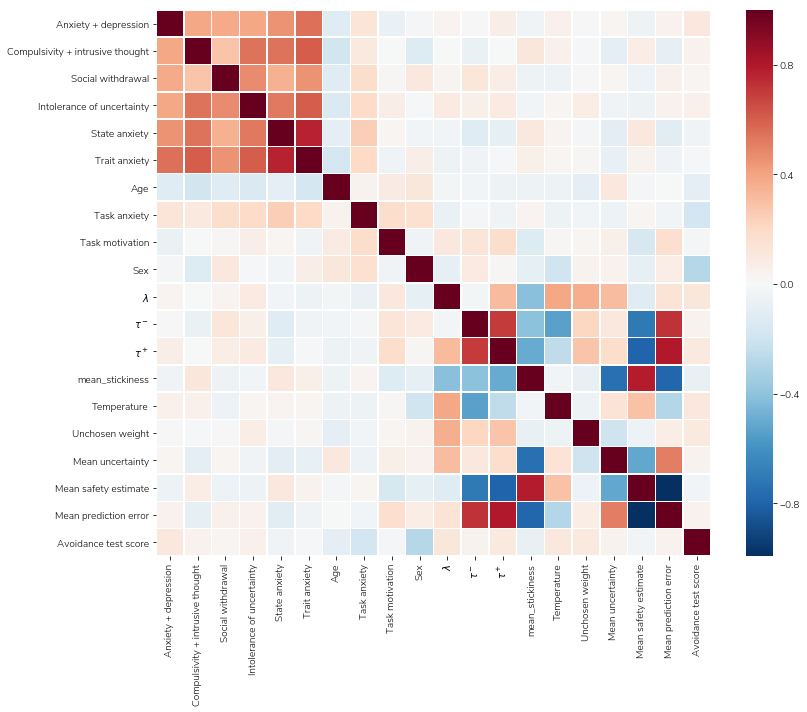

In [134]:
f, ax = plt.subplots(figsize=(12,10), facecolor='white')    
corr = full_df[[i for i in full_df.columns if 'Subject' not in i and 'hpd' not in i and 'sd_' not in i and 'error' not in i]].corr()
columns = ['Anxiety + depression', 'Compulsivity + intrusive thought', 'Social withdrawal', 'Intolerance of uncertainty', 'State anxiety', 
          'Trait anxiety', 'Age', 'Task anxiety', 'Task motivation', 'Sex', r'$\lambda$', r'$\tau^-$', r'$\tau^+$', 'mean_stickiness',
          'Temperature', 'Unchosen weight', 'Mean uncertainty', 'Mean safety estimate', 'Mean prediction error', 'Avoidance test score']
corr.columns = columns
corr.index = columns
sns.heatmap(corr, cmap='RdBu_r', linewidths=.5, ax=ax)
plt.tight_layout()

Specify the outcomes and predictors for our linear models

In [84]:
outcomes = ['mean_tau_p', 'mean_tau_n', 'mean_value', 'mean_uncertainty', 'mean_decay', 'mean_temp', 'mean_stickiness']
# outcomes = ['tau_p', 'tau_n', 'mean_value', 'mean_uncertainty']
# outcomes = ['mean_value', 'mean_uncertainty']

predictors = (['STICSA_T', 'age', 'sex', 'mean_health'],
              ['IUS', 'age', 'sex', 'mean_health'],
              ['STICSA_S', 'age', 'sex', 'mean_health'],
              ['AD', 'Compul', 'SW', 'age', 'sex', 'mean_health'],
              ['anxiety'])


### Fit the models

In [85]:
from bambi import Family, Prior
import pymc3 as pm
import dill

models_dict = OrderedDict()
results_dict = OrderedDict()

for n, outcome in enumerate(outcomes):
    
    models_dict[outcome] = []
    results_dict[outcome] = []
    
    for nn in range(len(predictors)):

        model = Model(full_df)
        model.predictors = predictors[nn]
        model.outcome = outcome
        model.name = outcome + '__' + '_'.join(predictors[nn])

        with open('../Data/regression_models/models/{0}.pkl'.format(model.name), 'wb') as file:
            dill.dump(model, file)
        

In [108]:
import dill
models = []

for m in tqdm([i for i in os.listdir('../Data/regression_models/results')]):
    with open(os.path.join('../Data/regression_models/results', m), 'rb') as f:
        models.append(dill.load(f))

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:42<00:00,  1.09s/it]


### Plot the results

In [109]:
summary_dfs = []
for n, lm in tqdm(enumerate(models)):
    summary = lm[1000:].summary()
    summary = summary[~summary.index.isin(['Intercept', 'sex', 'mean_health', 'age'])]
    summary = summary[~summary.index.str.contains('_sd')]
    summary['outcome'] = lm.model.outcome
    summary_dfs.append(summary)
df = pd.concat(summary_dfs)

factor_df = df[df.index.isin(['AD', 'Compul', 'SW'])]
anx_df = df[df.index.isin(['IUS', 'STICSA_T', 'STICSA_S'])]


35it [00:57,  1.76s/it]


In [110]:
anx_df = anx_df[~((anx_df['outcome'].str.contains('decay')) | (anx_df['outcome'].str.contains('stick')) | (anx_df['outcome'].str.contains('temp')))].reset_index(drop=True)
factor_df = factor_df[~((factor_df['outcome'].str.contains('decay')) | (factor_df['outcome'].str.contains('stick')) | (factor_df['outcome'].str.contains('temp')))].reset_index(drop=True)

In [111]:
anx_df[~((anx_df['outcome'].str.contains('decay')) | (anx_df['outcome'].str.contains('stick')) | (anx_df['outcome'].str.contains('temp')))]

,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin,outcome
0,0.088093,0.049686,-0.008137,0.186219,4000,0.999810,mean_tau_n
1,-0.084528,0.048551,-0.180282,0.009268,4000,0.999976,mean_tau_n
2,-0.015676,0.049691,-0.111651,0.081211,4000,0.999756,mean_tau_n
3,-0.030020,0.049930,-0.129915,0.064799,4000,0.999957,mean_tau_p
4,0.098149,0.048827,0.007973,0.195263,4000,1.000042,mean_tau_p
5,0.066295,0.048367,-0.028342,0.158195,4000,1.000125,mean_tau_p
6,-0.024324,0.049344,-0.117889,0.073354,4000,1.000284,mean_uncertainty
7,-0.084948,0.047929,-0.177204,0.008585,4000,0.999967,mean_uncertainty
8,-0.066149,0.048822,-0.158430,0.032161,4000,0.999757,mean_uncertainty
9,-0.044367,0.048823,-0.146707,0.046100,4000,0.999927,mean_value


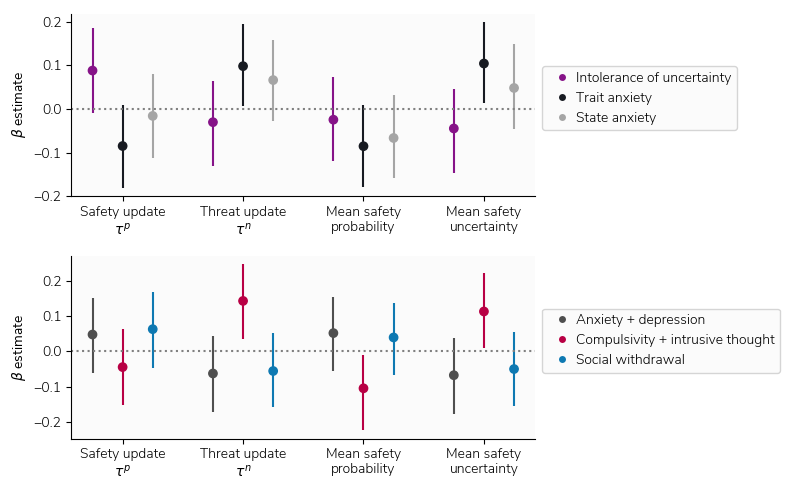

In [112]:
f, ax = plt.subplots(2, 1, figsize=(8, 5), dpi=100, facecolor='white')

# Nicer looking outcome names
outcomes_pretty = ['Safety update\n$\\tau^p$', 'Threat update\n$\\tau^n$', 'Mean safety\nprobability', 'Mean safety\nuncertainty']

# Plot anxiety results
anx_df.loc[:, 'predictor'] = anx_df.index
xpos = np.arange(len(anx_df)).astype(float)
for i in range(len(outcomes_pretty)):
    xpos[i*3:i*3+3] += i * 1
ax[0].scatter(xpos, 'mean', facecolors=pal[3:], data=anx_df, label=None)
ax[0].errorbar(xpos, 'mean', yerr=[anx_df['mean'] - anx_df['hpd0.95_lower'], 
                                anx_df['hpd0.95_upper'] - anx_df['mean']], fmt='none', label=None, ecolor=pal[3:], data=anx_df)  
ax[0].axhline(0, linestyle=':', c='grey')
ax[0].set_xticks(np.arange(len(outcomes_pretty)) * 4 + 1)
ax[0].set_xticklabels(outcomes_pretty)
ax[0].set_ylabel(r"$\beta$ estimate")

legend_elements = [Line2D([0], [0], marker='o', color='None', label='Intolerance of uncertainty', markerfacecolor=pal[3], markersize=5),
                   Line2D([0], [0], marker='o', color='None', label='Trait anxiety', markerfacecolor=pal[4], markersize=5),
                   Line2D([0], [0], marker='o', color='None', label='State anxiety', markerfacecolor=pal[5], markersize=5)]
ax[0].legend(handles=legend_elements, loc='upper left', ncol=1, handletextpad=0.01, mode=None, columnspacing=0.1, 
            bbox_to_anchor=(1, 0.75))

# Plot factor results
factor_df.loc[:, 'predictor'] = factor_df.index
xpos = np.arange(len(factor_df)).astype(float)
for i in range(len(outcomes_pretty)):
    xpos[i*3:i*3+3] += i * 1
ax[1].scatter(xpos, 'mean', facecolors=pal[:3], data=factor_df, label=None)
ax[1].errorbar(xpos, 'mean', yerr=[factor_df['mean'] - factor_df['hpd0.95_lower'], 
                                factor_df['hpd0.95_upper'] - factor_df['mean']], fmt='none', label=None, ecolor=pal[:3], data=factor_df)  
ax[1].axhline(0, linestyle=':', c='grey')
ax[1].set_xticks(np.arange(len(outcomes_pretty)) * 4 + 1)
ax[1].set_xticklabels(outcomes_pretty)
ax[1].set_ylabel(r"$\beta$ estimate")

legend_elements = [Line2D([0], [0], marker='o', color='None', label='Anxiety + depression', markerfacecolor=pal[0], markersize=5),
                   Line2D([0], [0], marker='o', color='None', label='Compulsivity + intrusive thought', markerfacecolor=pal[1], markersize=5),
                   Line2D([0], [0], marker='o', color='None', label='Social withdrawal', markerfacecolor=pal[2], markersize=5)]
ax[1].legend(handles=legend_elements, loc='upper left', ncol=1, handletextpad=0.01, mode=None, columnspacing=0.1, 
            bbox_to_anchor=(1, 0.75))

sns.despine()
plt.tight_layout()
plt.savefig('regression_plot.svg')
plt.savefig('regression_plot.png')

,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin,outcome
AD,0.012452,0.055043,-0.094586,0.116538,4000,0.999760,mean_decay
Compul,-0.028561,0.053594,-0.133032,0.074738,4000,1.000071,mean_decay
SW,0.041069,0.053413,-0.057314,0.150858,4000,0.999766,mean_decay
anxiety,-0.057788,0.049175,-0.152523,0.038491,4000,0.999857,mean_decay
IUS,0.091735,0.049194,-0.002060,0.189233,4000,0.999800,mean_decay
STICSA_S,-0.032834,0.047876,-0.126705,0.060914,4000,0.999839,mean_decay
STICSA_T,-0.044135,0.049778,-0.141138,0.050566,4000,1.000000,mean_decay
AD,-0.013747,0.055592,-0.122931,0.094060,4000,0.999775,mean_stickiness
Compul,-0.097556,0.053830,-0.207405,0.007128,4000,0.999755,mean_stickiness
SW,0.140679,0.054143,0.031667,0.242670,4000,0.999781,mean_stickiness


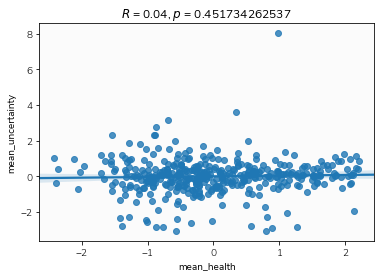

In [117]:
x = 'mean_health'
y = 'mean_uncertainty'
rr = pearsonr(full_df[x], full_df[y])
plt.figure(facecolor='white')
sns.regplot(x, y, data=full_df)
plt.title("$R$ = {0}, $p$ = {1}".format(np.round(rr[0], 2), np.round(rr[1], 50)));
# plt.savefig("value_anxiety.png")

## Trialwise regressions

In [278]:
trialwise_df = pd.read_csv('../Data/simulated_data.csv')
trialwise_df.Subject = trialwise_df.Subject.str.replace('data_', '')

In [185]:
qns = qns.drop_duplicates('Subject')

In [279]:
trialwise_df = pd.merge(trialwise_df, full_df, on='Subject')
# trialwise_df = pd.merge(trialwise_df, avoidance, on='Subject')
trialwise_df['trial_number'] = np.tile(np.arange(260), len(trialwise_df) / 260)

In [281]:
trialwise_df.Subject.unique().shape

(400L,)

In [188]:
trialwise_df[trialwise_df['trial_number'] == i].columns

Index([u'Unnamed: 0_x', u'value', u'alpha_0', u'beta_0', u'alpha_1', u'o',
       u'o2', u'beta_1', u'var_0', u'var_1', u'value_0', u'value_1',
       u'unchosen_0', u'unchosen_1', u'Subject', u'Run', u'Outcome',
       u'True_response', u'sim_model_input_0', u'alpha_0_sim', u'beta_0_sim',
       u'decay_sim', u'tau_n_sim', u'tau_p_sim', u'temp_sim',
       u'unchosen_p_sim', u'var_weight_sim', u'value_sim', u'Response',
       u'Unnamed: 0_y', u'AD', u'Compul', u'SW', u'IUS', u'STICSA_S',
       u'STICSA_T', u'age', u'anxiety', u'asteroid_rating', u'sex',
       u'mean_health', u'trial_number'],
      dtype='object')

In [189]:
import statsmodels.api as sm

In [282]:
preds = ['age', 'sex', 'mean_health', 'AD', 'Compul', 'SW']
betas = np.empty((520, len(preds) + 1))

for i in tqdm(range(520)):
    if i < 260:
        X = trialwise_df[trialwise_df['trial_number'] == i][preds]
        X = sm.add_constant(X)
        y = trialwise_df[trialwise_df['trial_number'] == i]['value_0']
    else:
        X = trialwise_df[trialwise_df['trial_number'] == i - 260][preds]
        X = sm.add_constant(X)
        y = trialwise_df[trialwise_df['trial_number'] == i - 260]['value_1']
    model = sm.OLS(y,X)
    results = model.fit()
    betas[i, :] = results.params

100%|████████████████████████████████████████████████████████████████████████████████| 520/520 [00:15<00:00, 33.88it/s]


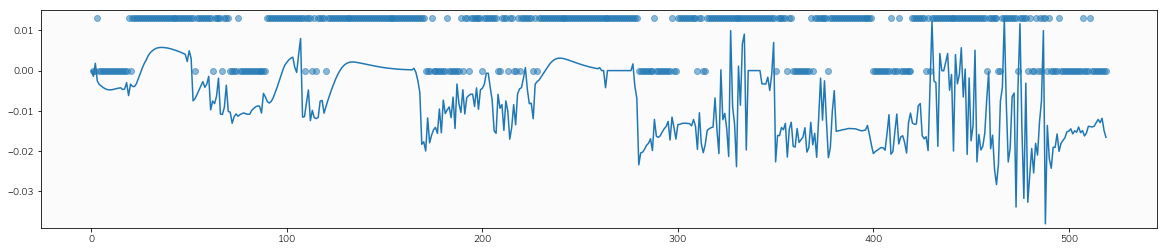

In [289]:
b = 4
plt.figure(figsize=(20, 4), facecolor='white')
plt.scatter(range(520), np.hstack([trialwise_df[:260]['o'], trialwise_df[:260]['o2']]) * betas[:, b].max(), alpha=0.5)
plt.ylim(betas[:, b].min() - 0.001, betas[:, b].max() + 0.002)
plt.plot(betas[:, b])

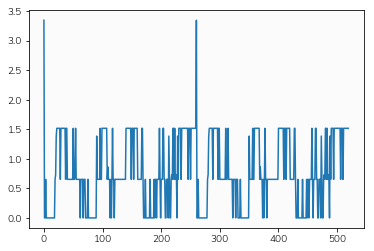

In [303]:
plt.plot(np.hstack([trialwise_df[260:520]['beta_0'], trialwise_df[260:520]['beta_1']]))

In [300]:
trialwise_df['beta_0'][0]

3.4089063935159367

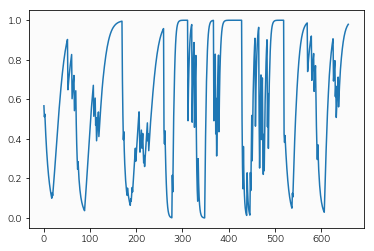

In [284]:
plt.plot(trialwise_df[:660]['value_0'])

In [168]:
results.params

const       0.905272
age         0.001419
sex        -0.009391
STICSA_T   -0.000200
IUS         0.000939
dtype: float64

In [ ]:
plt.figure(figsize=(5, 3.5), dpi=100)
sns.regplot('mean_var_weight', 'STICSA_T', data=full_df, color=pal[0], label='Trait')
sns.regplot('mean_var_weight', 'STICSA_S', data=full_df, color=pal[1], label='State')
plt.legend()
plt.savefig("var_weight_anxiety.png")

In [ ]:
len(full_df)

In [86]:
simulated = pd.read_csv('../Data/simulated_data.csv')
simulated.Subject = simulated.Subject.str.replace('data_', '')

In [87]:
a = pd.merge(simulated, qns, on='Subject')

In [57]:
from sklearn.cluster import KMeans

y_pred = KMeans(n_clusters=3).fit_predict(full_df[['AD', 'Compul', 'SW']])

In [72]:
qns['STICSA_T'].max()

76

('For n_clusters =', 2, 'The average silhouette_score is :', 0.4309677111174645)
('For n_clusters =', 3, 'The average silhouette_score is :', 0.32471593757528866)
('For n_clusters =', 4, 'The average silhouette_score is :', 0.2720786388624634)
('For n_clusters =', 5, 'The average silhouette_score is :', 0.26246662865000653)
('For n_clusters =', 6, 'The average silhouette_score is :', 0.251458330231966)


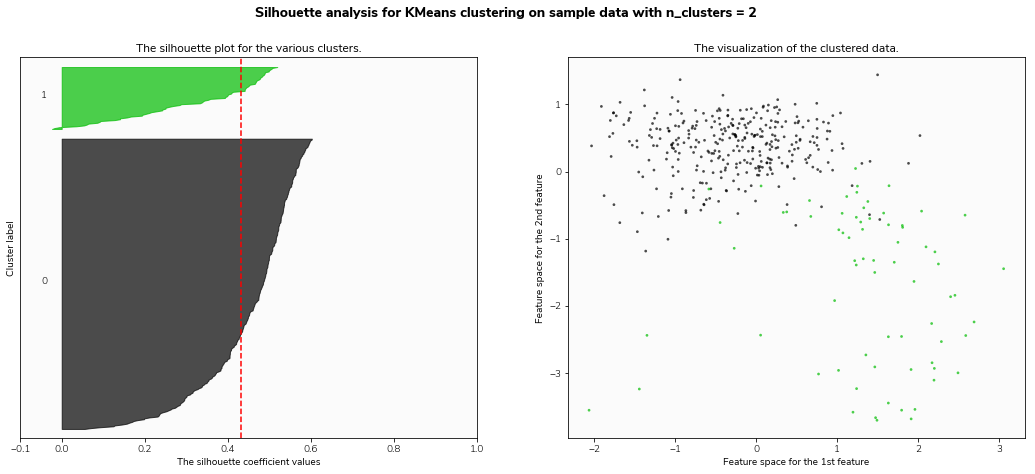

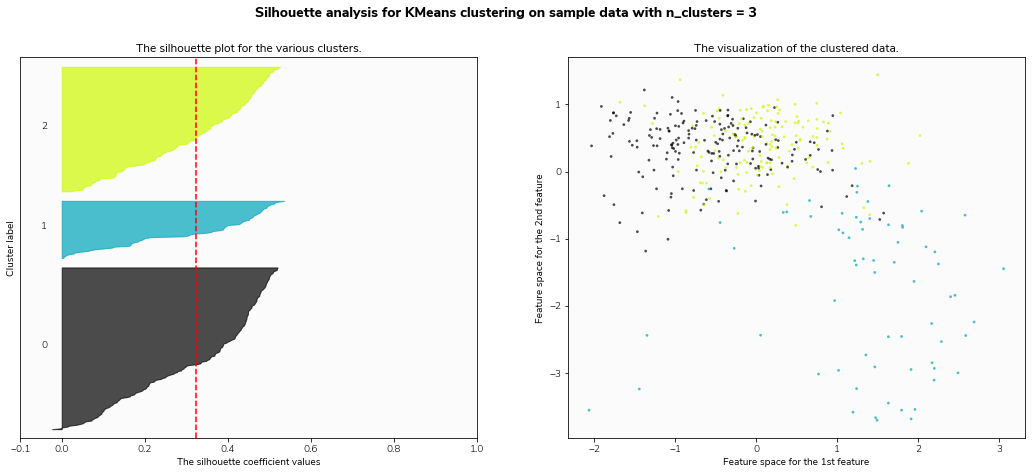

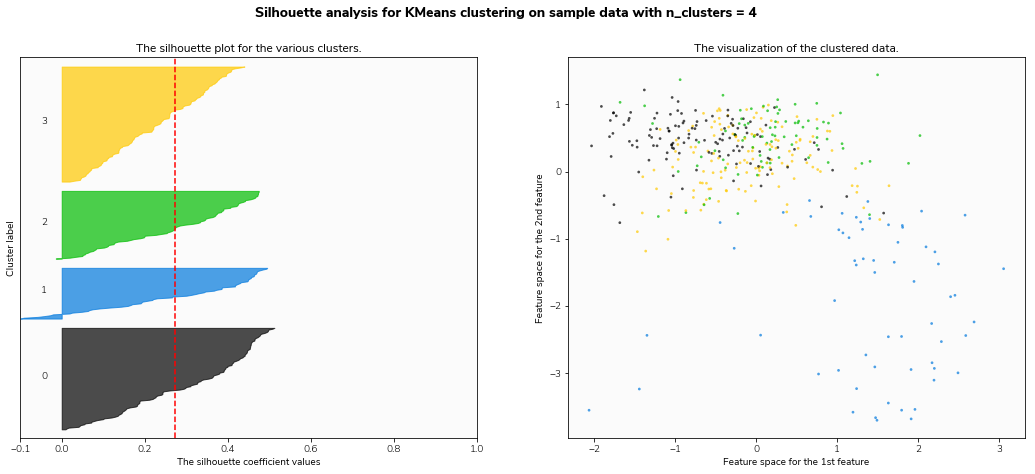

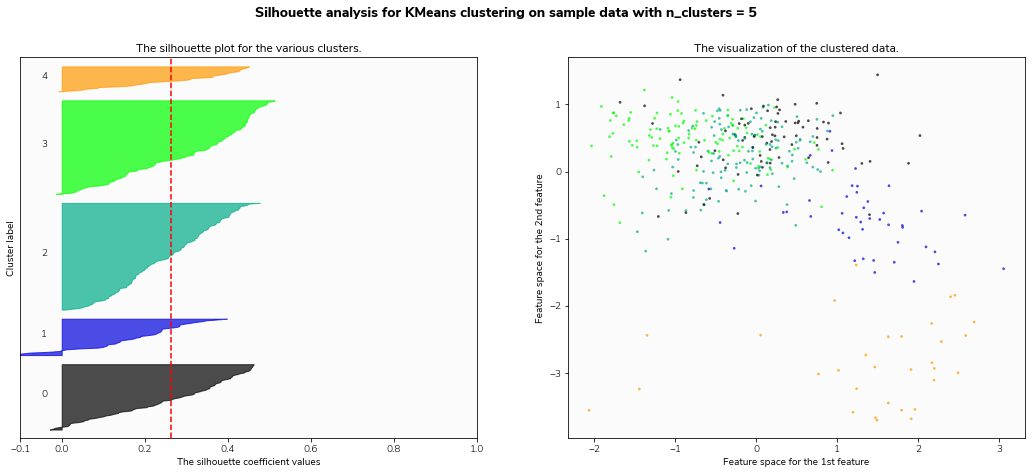

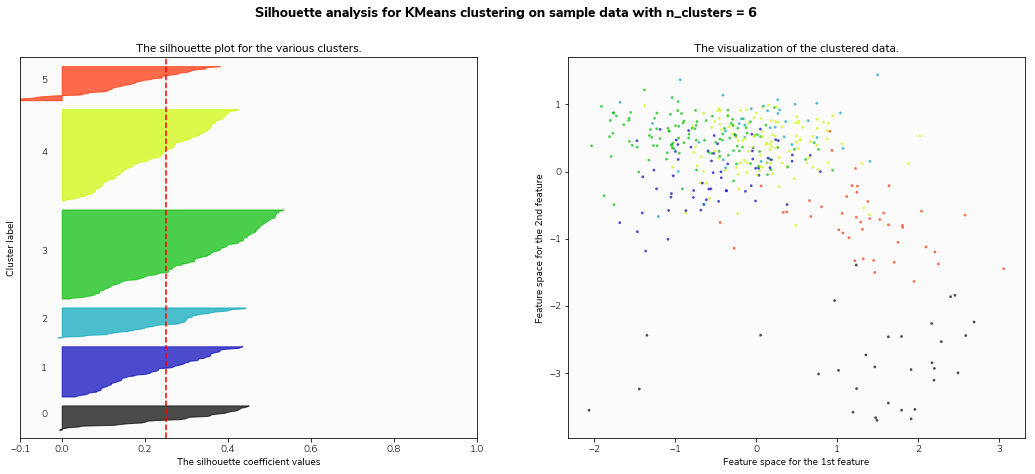

In [20]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

X = full_df[['mean_tau_p', 'mean_tau_n', 'mean_decay', 'mean_stickiness', 'mean_temp']].values

range_n_clusters = [2, 3, 4, 5, 6]

Sum_of_squared_distances = []

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, facecolor='white')
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    Sum_of_squared_distances.append(clusterer.inertia_)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

#     # Labeling the clusters
#     centers = clusterer.cluster_centers_
#     # Draw white circles at cluster centers
#     ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
#                 c="white", alpha=1, s=200, edgecolor='k')

#     for i, c in enumerate(centers):
#         ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
#                     s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

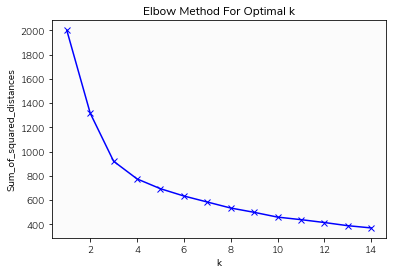

In [24]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [30]:
km = KMeans(n_clusters=4)
pred = km.fit_predict(X)

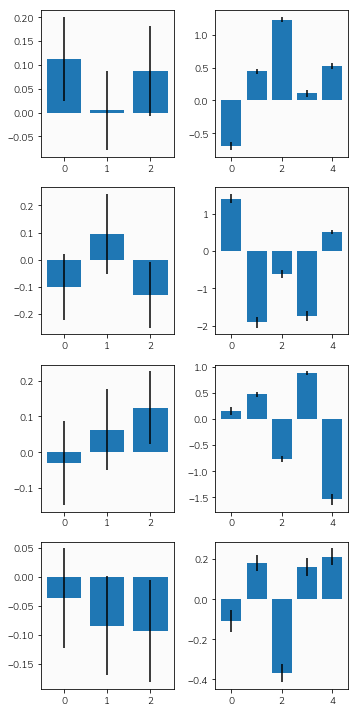

In [56]:
f, ax = plt.subplots(4, 2, figsize=(5, 10))

for i in range(4):
    cluster_idx = np.where(pred == i)
    ax[i, 0].bar(range(3), full_df.iloc[cluster_idx[0]][['AD', 'Compul', 'SW']].mean(), yerr=full_df.iloc[cluster_idx[0]][['AD', 'Compul', 'SW']].sem())
    ax[i, 1].bar(range(5), full_df.iloc[cluster_idx[0]][['mean_tau_p', 'mean_tau_n', 'mean_decay', 'mean_stickiness', 'mean_temp']].mean(), 
                 yerr=full_df.iloc[cluster_idx[0]][['mean_tau_p', 'mean_tau_n', 'mean_decay', 'mean_stickiness', 'mean_temp']].sem())
    
    
plt.tight_layout()

## Cross-decomposition

In [65]:
from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA
from sklearn.model_selection import train_test_split

Y = full_df[['AD', 'Compul', 'SW']].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)


In [66]:
cca = CCA(n_components=3)
cca.fit(X_train, Y_train)
X_train_r, Y_train_r = cca.transform(X_train, Y_train)
X_test_r, Y_test_r = cca.transform(X_test, Y_test)

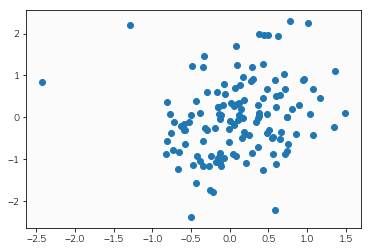

In [75]:
plt.scatter(X_test_r[:, 1], Y_test_r[:, 1])

In [73]:
X_test_r.shape

(132L, 2L)

<BarContainer object of 3 artists>

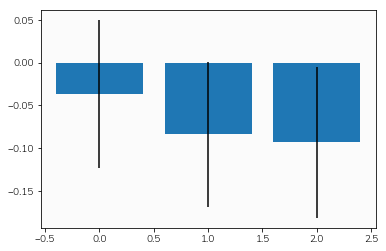

In [47]:
plt.bar(range(3), full_df.iloc[cluster_idx[0]][['AD', 'Compul', 'SW']].mean(), yerr=full_df.iloc[cluster_idx[0]][['AD', 'Compul', 'SW']].sem())

In [33]:
full_df

,AD,Compul,SW,Subject,IUS,STICSA_S,STICSA_T,age,anxiety,asteroid_rating,...,hpd_97.5_decay,hpd_97.5_stickiness,hpd_97.5_tau_n,hpd_97.5_tau_p,hpd_97.5_temp,hpd_97.5_unchosen_p,mean_uncertainty,mean_value,mean_pe,mean_health
0,-0.328644,-0.662831,-0.776643,54f74bc3fdf99b46ee467b27,0.051788,0.365019,-0.761043,-0.356639,-1.311380,-1.123572,...,-0.908014,0.541686,0.108498,-0.516768,-1.336367,0.212972,-0.117059,-0.563285,0.667788,0.131824
1,1.577596,0.074454,1.264454,550c3ed5fdf99b3039d68894,1.905269,-0.497910,0.159152,0.187433,-0.719594,0.342311,...,1.822024,0.470074,0.354710,-0.876186,0.516912,0.415662,0.029343,-0.187683,0.229322,-0.179522
2,-0.071180,0.302968,1.105182,556db04dfdf99b26054b1768,0.814986,-0.239031,0.661076,-0.356639,-0.588087,0.233727,...,0.398062,-0.063168,0.479015,0.166943,0.625786,0.414944,-0.264011,0.333365,-0.367955,-1.017432
3,0.751964,0.181690,0.919872,55747e4afdf99b6752df4183,-0.057240,0.192433,-1.012005,1.057947,1.647547,0.830939,...,0.615894,0.628710,0.525646,-0.523642,-0.286365,0.460260,0.370770,-0.122821,0.107415,-0.326645
4,0.780654,0.213023,1.131550,557c0bd8fdf99b120dc45dde,0.160817,1.831997,0.912038,0.949133,-0.818225,-1.286448,...,-0.092845,-5.087646,-1.066289,1.336712,0.773395,0.372051,-0.311677,1.984374,-2.043621,-0.921059
5,-1.408059,-1.472532,1.274192,559744acfdf99b590e1e9299,0.487901,-1.015667,-1.095659,0.405061,-0.620964,-0.092025,...,0.637413,0.098987,0.203505,0.305744,0.508870,-0.565547,-0.070226,0.334884,-0.189390,-0.256478
6,-0.762082,-1.607500,0.467351,55a2fa33fdf99b073cd94947,0.705958,-0.756788,-1.012005,1.057947,1.877685,0.830939,...,1.973382,0.469139,0.349619,-0.517939,0.465116,0.378522,-0.051057,-0.076962,0.123653,-0.586203
7,0.769068,-0.178932,-0.412838,55b8113efdf99b4633359b7b,-0.711409,-1.101960,-1.095659,-0.030196,-0.259317,0.722355,...,-0.200988,0.581625,-0.162883,-0.001303,-1.264313,-0.218593,0.047055,-0.032178,0.020909,1.594371
8,0.407589,-0.232428,0.995250,55c4fc3dfdf99b559867a416,-0.384325,-0.843081,0.159152,-0.356639,0.792746,-0.254901,...,0.859831,0.425458,0.595816,-0.409335,-0.383165,0.380327,0.097267,-0.114603,0.099572,-0.705473
9,-1.469624,-0.730093,1.194862,5601bbdae372c00011bd3b71,-0.057240,-0.497910,-1.346621,0.731504,-1.114118,0.830939,...,0.857249,-0.170049,0.226241,-0.596643,0.846093,0.348821,1.030456,-0.163391,0.286144,-0.547132


In [95]:
len(full_df)

400

In [108]:
data_dir = '../Data'

count = 0

files = [i for i in os.listdir(data_dir) if 'game_data' in i or 'questionnaire_data' in i]

subs = []

for i in tqdm(files):
    sub = re.search('(?<=data_)[a-z0-9]+', i).group()
    if sub in full_df['Subject'].tolist() and sub not in subs:
        if 'questionnaire' in i:
            shutil.copyfile(os.path.join(data_dir, i), os.path.join('../new_data/questionnaire', i))
            subs.append(sub)
        if 'game' in i:
            df = pd.read_csv(os.path.join(data_dir, i))
            if df[' trial'].max() > 260:
                shutil.copyfile(os.path.join(data_dir, i), os.path.join('../new_data/game', i))
                subs.append(sub)


100%|██████████████████████████████████████████████████████████████████████████████| 1003/1003 [00:21<00:00, 47.46it/s]


269

In [79]:
i = os.listdir(data_dir)[10]

In [82]:
import re

In [88]:
sub = re.search('(?<=data_)[a-z0-9]+', i).group()
print sub

AttributeError: 'NoneType' object has no attribute 'group'

In [ ]:
full_df['Subject'].tolist()